<a href="https://colab.research.google.com/github/LazaroR-u/GSoC_QMLHEP_2024/blob/main/tasks/task2_graph_quark_gluon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GSoC 2024 ML4SCI QML-HEP Tasks
**Diaz Lievano Lazaro Raul**

## Task II: Classical Graph Neural Network (GNN)
For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description.
https://zenodo.org/records/3164691#.YigdGt9MHrB

* Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges.

* Discuss the resulting performance of the 2 chosen architectures.

In [ ]:
%%capture
pip install torch_geometric

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
import torch_geometric.utils as utils
from torch_geometric.utils.convert import from_networkx
from torch_geometric.utils import to_networkx

from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

## load packages

In [ ]:
with np.load('QG_jets.npz') as data:
    X = data['X']
    Y = data["y"]

In [ ]:
def distance_n_phi(rap1, rap2, phi1, phi2):
    return ((rap2 - rap1)**2 + (phi2 - phi1)**2)**0.5

def event_to_graph(x, label):
    particles = pd.DataFrame(x, columns=["Pt", "rapidity", "azimuthal_angle", "pdgid"])
    particles = particles.loc[(particles != 0).any(axis=1)]

    nodes = []
    for i in range(len(particles)):
        nodes.append([particles.iloc[i, 0], particles.iloc[i, 3]])

    edges = []
    for i in range(len(particles)):
        for j in range(len(particles)):
            if i != j:
                edge = [i, j] if i < j else [j, i]
                edges.append(edge)

    weights = []
    for i, j in edges:
        weight = distance_n_phi(particles.iloc[i, 1], particles.iloc[j, 1], particles.iloc[i, 2], particles.iloc[j, 2])
        weights.append(weight)

    nodes = np.array(nodes)
    edges = np.array(edges).T
    weights_np = np.round(np.array(weights) * 10)

    y = torch.tensor([label], dtype=torch.long)
    x = torch.tensor(nodes, dtype=torch.float)
    edge_index = torch.tensor(edges, dtype=torch.long)

    edge_attr = torch.tensor(weights_np, dtype=torch.float)
    edge_attr = edge_attr.unsqueeze(1)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.edge_index = utils.to_undirected(data.edge_index)

    return data

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_list):
        super(CustomDataset, self).__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

## graph dataset

In [ ]:
n = 1000

with np.load('QG_jets.npz') as data:
    X = data['X']
    Y = data["y"]

indices_etiqueta_0 = np.where(Y == 0)[0]
indices_etiqueta_1 = np.where(Y == 1)[0]

indices_etiqueta_0_seleccionados = np.random.choice(indices_etiqueta_0, int(n/2), replace=False)
indices_etiqueta_1_seleccionados = np.random.choice(indices_etiqueta_1, int(n/2), replace=False)

indices_seleccionados = np.concatenate([indices_etiqueta_0_seleccionados, indices_etiqueta_1_seleccionados])

X_seleccionados = X[indices_seleccionados]
Y_seleccionados = Y[indices_seleccionados]

In [ ]:
graph_dataset = []
n=1000
for event in range(n):
    graph = event_to_graph(X[event], Y[event])
    graph_dataset.append(graph)

graph_dataset = CustomDataset(graph_dataset)
graph_data = graph_dataset[0]
graph_data

Data(x=[18, 2], edge_index=[2, 306], edge_attr=[306, 1], y=[1])

In [ ]:
print(f'Number of nodes: {graph_data.num_nodes}')
print(f'Number of edges: {graph_data.num_edges}')
print(f'Average node degree: {graph_data.num_edges / graph_data.num_nodes:.2f}')
print(f'Has isolated nodes: {graph_data.has_isolated_nodes()}')
print(f'Has self-loops: {graph_data.has_self_loops()}')
print(f'Is undirected: {graph_data.is_undirected()}')

Number of nodes: 18
Number of edges: 306
Average node degree: 17.00
Has isolated nodes: False
Has self-loops: False
Is undirected: True


tensor(1)


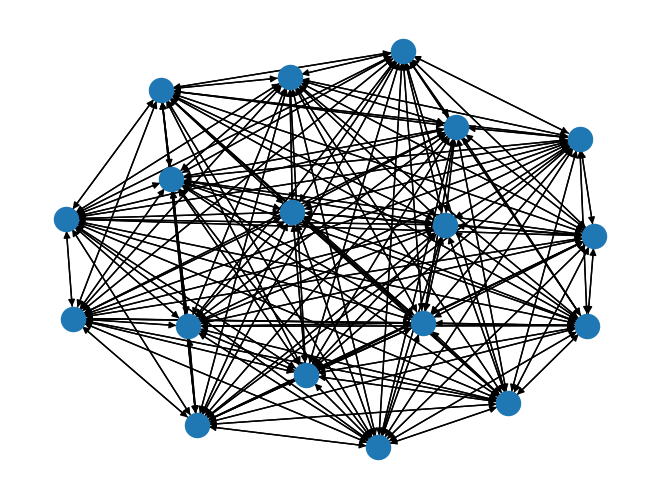

In [ ]:
nx.draw(to_networkx(graph_data))
print(graph_data["y"][0])

In [ ]:
graph_dataset = graph_dataset.shuffle()

train_dataset = graph_dataset[:int(n*0.8)]
test_dataset = graph_dataset[int(n*0.8):n]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 800
Number of test graphs: 200


In [ ]:
lbl = []
for i in range(len(graph_dataset)):
  lbl.append(Y[i])
pd.Series(lbl).value_counts()

1.0    511
0.0    489
dtype: int64

## Model 1: batch 128. GCNConv

In [ ]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 128
DataBatch(x=[5364, 2], edge_index=[2, 248174], edge_attr=[248174, 1], y=[128], batch=[5364], ptr=[129])

Step 2:
Number of graphs in the current batch: 128
DataBatch(x=[5559, 2], edge_index=[2, 271252], edge_attr=[271252, 1], y=[128], batch=[5559], ptr=[129])

Step 3:
Number of graphs in the current batch: 128
DataBatch(x=[5334, 2], edge_index=[2, 255294], edge_attr=[255294, 1], y=[128], batch=[5334], ptr=[129])

Step 4:
Number of graphs in the current batch: 128
DataBatch(x=[5466, 2], edge_index=[2, 269940], edge_attr=[269940, 1], y=[128], batch=[5466], ptr=[129])

Step 5:
Number of graphs in the current batch: 128
DataBatch(x=[5595, 2], edge_index=[2, 286642], edge_attr=[286642, 1], y=[128], batch=[5595], ptr=[129])

Step 6:
Number of graphs in the current batch: 128
DataBatch(x=[5630, 2], edge_index=[2, 286254], edge_attr=[286254, 1], y=[128], batch=[5630], ptr=[129])

Step 7:
Number of graphs in the current batch: 32
DataBatch(x=[1

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(graph_dataset.num_node_features, 128)
        self.conv2 = GCNConv(128, 128)
        self.lin = Linear(128, graph_dataset.num_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x= F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)

        # 2. Readout layer
        x = global_mean_pool(x, batch)

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return F.log_softmax(x, dim=1)


model = GCN()
print(model)

GCN(
  (conv1): GCNConv(2, 128)
  (conv2): GCNConv(128, 128)
  (lin): Linear(in_features=128, out_features=2, bias=True)
)


In [ ]:
model = GCN()

epochs = 25
lr = 0.1

criterion = torch.nn.CrossEntropyLoss()
for i in range(epochs):
  if epochs < 15:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  else:
    optimizer = torch.optim.Adam(model.parameters(), lr=lr*0.1)



def train():
    model.train()

    for data in train_loader:
         out = model(data.x, data.edge_index, data.edge_attr, data.batch )
         loss = criterion(out, data.y)
         loss.backward()
         optimizer.step()
         optimizer.zero_grad()

def test(loader):
     model.eval()

     correct = 0
     for data in loader:
         out = model(data.x, data.edge_index, data.edge_attr, data.batch)
         pred = out.argmax(dim=1)
         correct += int((pred == data.y).sum())
     return correct / len(loader.dataset)


train_accuracy = []
test_accuracy = []
for epoch in range(1, epochs):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.5175, Val Acc: 0.4850
Epoch: 002, Train Acc: 0.5175, Val Acc: 0.4850
Epoch: 003, Train Acc: 0.5637, Val Acc: 0.5350
Epoch: 004, Train Acc: 0.5262, Val Acc: 0.4900
Epoch: 005, Train Acc: 0.6312, Val Acc: 0.6100
Epoch: 006, Train Acc: 0.6088, Val Acc: 0.5800
Epoch: 007, Train Acc: 0.6350, Val Acc: 0.6050
Epoch: 008, Train Acc: 0.7275, Val Acc: 0.7200
Epoch: 009, Train Acc: 0.7588, Val Acc: 0.7200
Epoch: 010, Train Acc: 0.7425, Val Acc: 0.6800
Epoch: 011, Train Acc: 0.7488, Val Acc: 0.7100
Epoch: 012, Train Acc: 0.7750, Val Acc: 0.7250
Epoch: 013, Train Acc: 0.6925, Val Acc: 0.6950
Epoch: 014, Train Acc: 0.7037, Val Acc: 0.7250
Epoch: 015, Train Acc: 0.7512, Val Acc: 0.7250
Epoch: 016, Train Acc: 0.7500, Val Acc: 0.7300
Epoch: 017, Train Acc: 0.7675, Val Acc: 0.7250
Epoch: 018, Train Acc: 0.7288, Val Acc: 0.7400
Epoch: 019, Train Acc: 0.7488, Val Acc: 0.7400
Epoch: 020, Train Acc: 0.7512, Val Acc: 0.7400
Epoch: 021, Train Acc: 0.7538, Val Acc: 0.7250
Epoch: 022, T

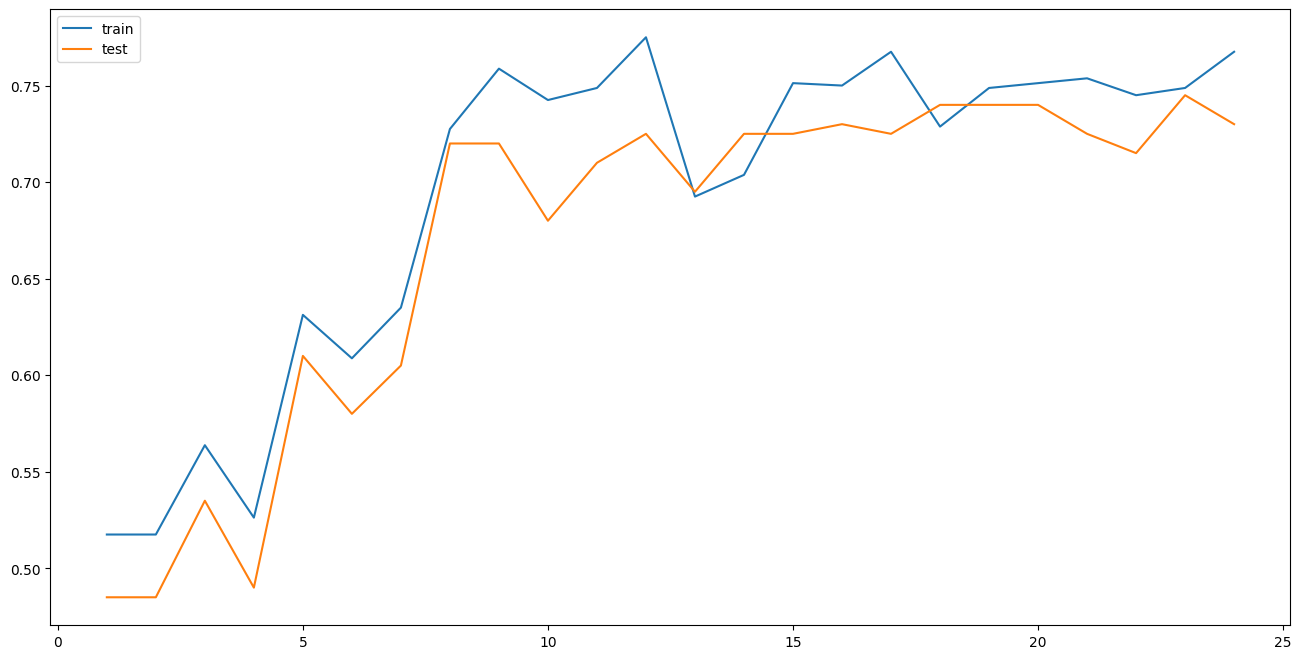

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(range(1,epochs), train_accuracy, label = "train")
plt.plot(range(1, epochs), test_accuracy, label = "test")
plt.legend()

In [ ]:
#Save the model and the optimizer
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy
}, 'modelo_entrenado.tar')


In [ ]:
#Load the model
checkpoint = torch.load('modelo_entrenado.tar')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_accuracy = checkpoint['train_accuracy']
test_accuracy = checkpoint['test_accuracy']

#Continue training the model since the last epoch saved
for epoch in range(epoch + 1, 40):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {test_acc:.4f}')


Epoch: 025, Train Acc: 0.7588, Val Acc: 0.7150
Epoch: 026, Train Acc: 0.7150, Val Acc: 0.7100
Epoch: 027, Train Acc: 0.7700, Val Acc: 0.7400
Epoch: 028, Train Acc: 0.7425, Val Acc: 0.7500
Epoch: 029, Train Acc: 0.7638, Val Acc: 0.7350
Epoch: 030, Train Acc: 0.7538, Val Acc: 0.7500
Epoch: 031, Train Acc: 0.7412, Val Acc: 0.7350
Epoch: 032, Train Acc: 0.7550, Val Acc: 0.7550
Epoch: 033, Train Acc: 0.7525, Val Acc: 0.7400
Epoch: 034, Train Acc: 0.7375, Val Acc: 0.7450
Epoch: 035, Train Acc: 0.7762, Val Acc: 0.7200
Epoch: 036, Train Acc: 0.7488, Val Acc: 0.7450
Epoch: 037, Train Acc: 0.7650, Val Acc: 0.7250
Epoch: 038, Train Acc: 0.7438, Val Acc: 0.7100
Epoch: 039, Train Acc: 0.7525, Val Acc: 0.7500


## model 2. batch 32. GCNConv

In [ ]:
batch_size = 32
train_loader2 = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader2 = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)

In [ ]:
class GCN2(torch.nn.Module):
    def __init__(self):
        super(GCN2, self).__init__()
        #torch.manual_seed(12345)
        self.conv1 = GCNConv(graph_dataset.num_node_features, 32)
        self.conv2 = GCNConv(32, 32)
        self.conv3 = GCNConv(32, 32)
        self.lin = Linear(32, graph_dataset.num_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x= F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index, edge_attr)
        # 2. Readout layer
        x = global_mean_pool(x, batch)

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return F.log_softmax(x, dim=1)

model2 = GCN2()
print(model2)

GCN2(
  (conv1): GCNConv(2, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (lin): Linear(in_features=32, out_features=2, bias=True)
)


In [ ]:
model2 = GCN2()

epochs = 25
lr = 0.1

criterion = torch.nn.CrossEntropyLoss()


for i in range(epochs):
  if epochs < 15:
    optimizer = torch.optim.Adam(model2.parameters(), lr=lr)
  else:
    optimizer = torch.optim.Adam(model2.parameters(), lr=lr*0.1)


def train():
    model2.train()

    for data in train_loader2:
         out = model2(data.x, data.edge_index, data.edge_attr, data.batch )
         loss = criterion(out, data.y)
         loss.backward()
         optimizer.step()
         optimizer.zero_grad()

def test(loader):
     model2.eval()

     correct = 0
     for data in loader:
         out = model2(data.x, data.edge_index, data.edge_attr, data.batch)
         pred = out.argmax(dim=1)
         correct += int((pred == data.y).sum())
     return correct / len(loader.dataset)

train_accuracy2 = []
test_accuracy2 = []
for epoch in range(1, epochs):
    train()
    train_acc = test(train_loader2)
    test_acc = test(test_loader2)
    train_accuracy2.append(train_acc)
    test_accuracy2.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.5250, Val Acc: 0.5100
Epoch: 002, Train Acc: 0.5575, Val Acc: 0.5550
Epoch: 003, Train Acc: 0.6450, Val Acc: 0.6250
Epoch: 004, Train Acc: 0.5800, Val Acc: 0.5400
Epoch: 005, Train Acc: 0.7350, Val Acc: 0.7400
Epoch: 006, Train Acc: 0.7525, Val Acc: 0.7100
Epoch: 007, Train Acc: 0.7538, Val Acc: 0.7550
Epoch: 008, Train Acc: 0.7225, Val Acc: 0.7250
Epoch: 009, Train Acc: 0.7500, Val Acc: 0.7100
Epoch: 010, Train Acc: 0.7688, Val Acc: 0.7350
Epoch: 011, Train Acc: 0.7475, Val Acc: 0.7550
Epoch: 012, Train Acc: 0.7238, Val Acc: 0.7150
Epoch: 013, Train Acc: 0.7800, Val Acc: 0.7450
Epoch: 014, Train Acc: 0.7425, Val Acc: 0.7400
Epoch: 015, Train Acc: 0.7750, Val Acc: 0.7450
Epoch: 016, Train Acc: 0.7438, Val Acc: 0.7550
Epoch: 017, Train Acc: 0.7738, Val Acc: 0.7500
Epoch: 018, Train Acc: 0.7150, Val Acc: 0.7250
Epoch: 019, Train Acc: 0.7775, Val Acc: 0.7400
Epoch: 020, Train Acc: 0.7488, Val Acc: 0.7450
Epoch: 021, Train Acc: 0.6775, Val Acc: 0.6750
Epoch: 022, T

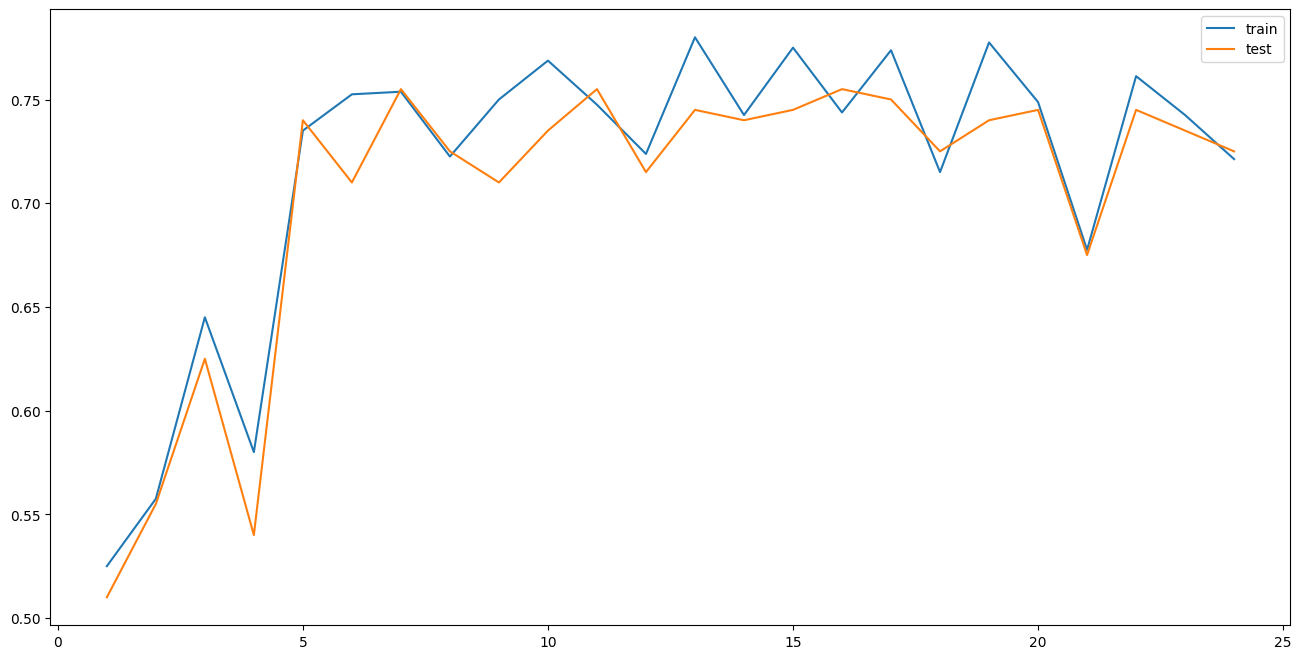

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(range(1, epochs), train_accuracy2, label = "train")
plt.plot(range(1, epochs), test_accuracy2, label = "test")
plt.legend()

#### GATConv

In [ ]:
import time

epochs = 20
batch_size = 128
train_loader4 = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader4 = DataLoader(test_dataset, batch_size = batch_size, shuffle = True)


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads, dropout=0.6)
        # On the Pubmed dataset, use `heads` output heads in `conv2`.
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1,
                             concat=False, dropout=0.6)

    def forward(self, x, edge_index):#, edge_attr):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))#, edge_attr))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

epochs = 20
hidden_channels = 8
heads = 8

model_gat = GAT(graph_dataset.num_features, hidden_channels, graph_dataset.num_classes, heads)
optimizer = torch.optim.Adam(model_gat.parameters(), lr=0.005, weight_decay=5e-4)


def train():
    model_gat.train()
    optimizer.zero_grad()
    for data in train_loader4:
      out = model_gat(data.x, data.edge_index)
      loss = F.cross_entropy(out, data.y)
      loss.backward()
      optimizer.step()
    return float(loss)


def test(loader):
    model_gat.eval()
    correct = 0
    total = 0

    for data in loader:
        out = model_gat(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        correct += int((pred == data.y).sum())
        total += len(data.y)

    return correct / total


times = []
start = time.time()
train_accuracy4 = []
test_accuracy4 = []
for epoch in range(1, epochs):
    train()
    train_acc = test(train_loader4)
    test_acc = test(test_loader4)
    train_accuracy4.append(train_acc)
    test_accuracy4.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {test_acc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

NameError: name 'GATConv' is not defined